In [1]:
# Add project root to path for imports
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

# Neural field package imports
from neural_field import SimulationConfig, create_simulator
from neural_field.config import (
    SimulationMode, RingMode, LateralKernelType, CrossKernelType,
    GridParams, TimeParams, LateralKernelParams, CrossKernelParams, InputParams, PhysicsParams
)
from neural_field.core import SpatialGrid, TrialResult
from neural_field.visualization import plot_results, plot_space_time, plot_candidates, plot_potential_and_force
from neural_field.visualization.kernels import plot_kernel
from neural_field.analysis import check_stability, search_stable_kernels
from neural_field.analysis.validation import calculate_force_at_dist, run_empirical_validation, particle_model
from neural_field.kernels import create_lateral_kernel, create_cross_kernel
from neural_field.kernels.physics import compute_bump_physics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Kilpatrick Replication

### 1.1 Attraction and Repellation (Full model)

/Users/maxnowa/Desktop/lab-rotation-schwalger/neural_field/visualization/simulation.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


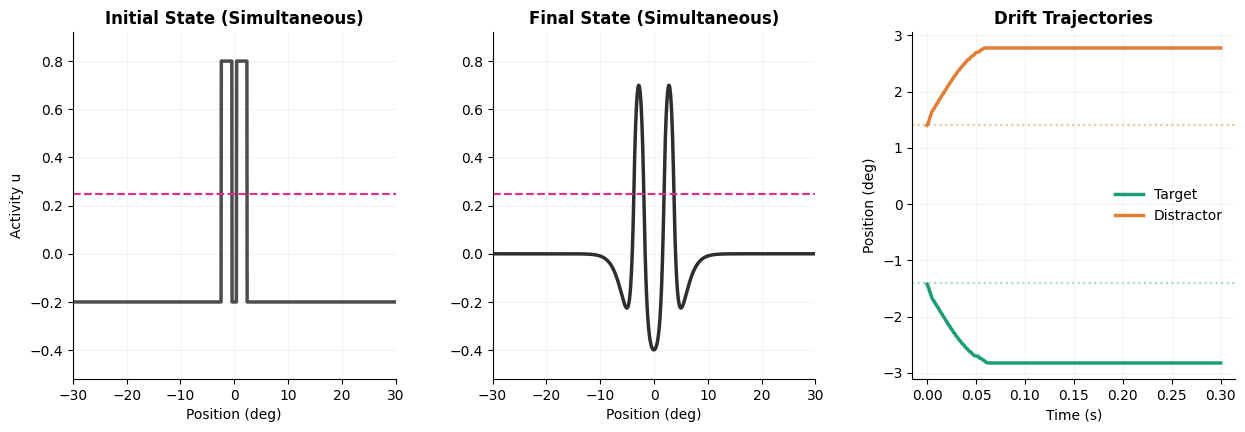

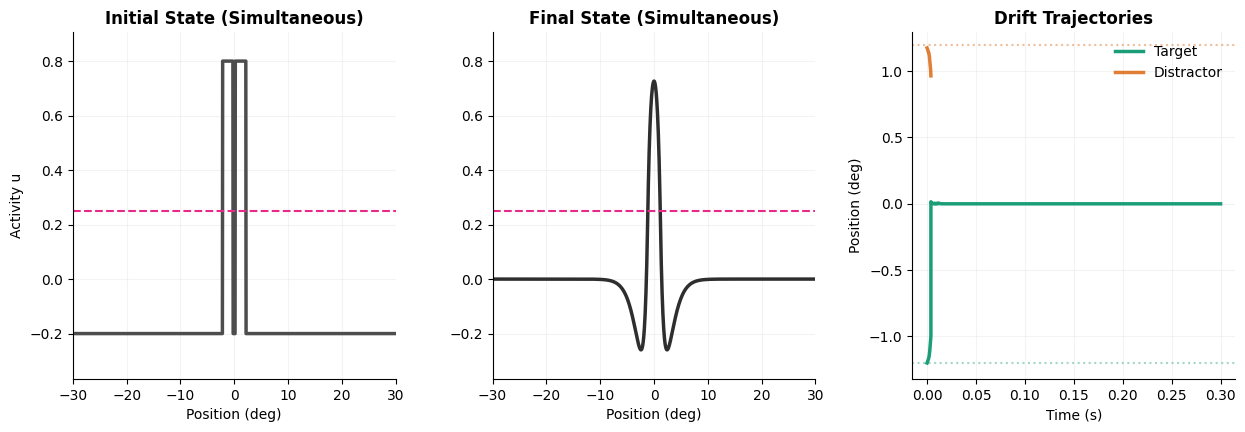

In [2]:
### repelling and attracting ###
# dx of 0.05 is strictly speaking not accurate enough but sufficient for this visualization

# Create configuration using new API
config = SimulationConfig(
    sim_mode=SimulationMode.FULL,
    ring_mode=RingMode.SINGLE,
    grid=GridParams(dx=0.05),
    time=TimeParams(eps=0.02, T_total=300),
    input=InputParams(width_input=2),
    lateral_kernel=LateralKernelParams(kernel_type=LateralKernelType.KILPATRICK),
)

# Create simulator
sim = create_simulator(config)

# Run repelling case
target_repel = -1.4
distractor_repel = 1.4
res1 = sim.run_trial(target_loc=target_repel, dist_loc=distractor_repel, 
                     with_noise=False, experiment_type="simultaneous")

# Run attracting case
target_attract = -1.2
distractor_attract = 1.2
res2 = sim.run_trial(target_loc=target_attract, dist_loc=distractor_attract, 
                     with_noise=False, experiment_type="simultaneous")

# Plot results
plot_results(sim.grid, res1, target_loc=target_repel, dist_loc=distractor_repel, 
             condition="Simultaneous", dt=config.dt, theta=config.theta)
plot_results(sim.grid, res2, target_loc=target_attract, dist_loc=distractor_attract, 
             condition="Simultaneous", dt=config.dt, theta=config.theta)

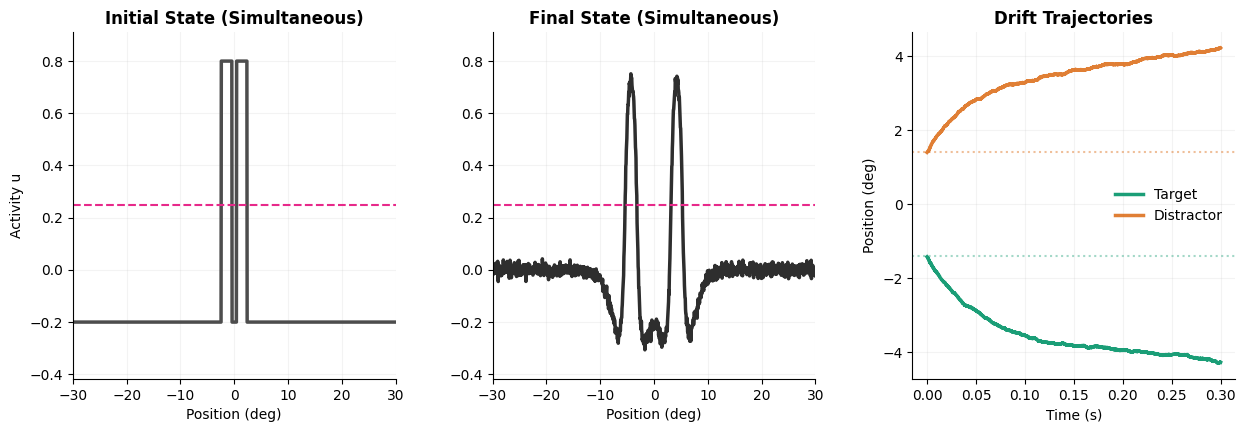

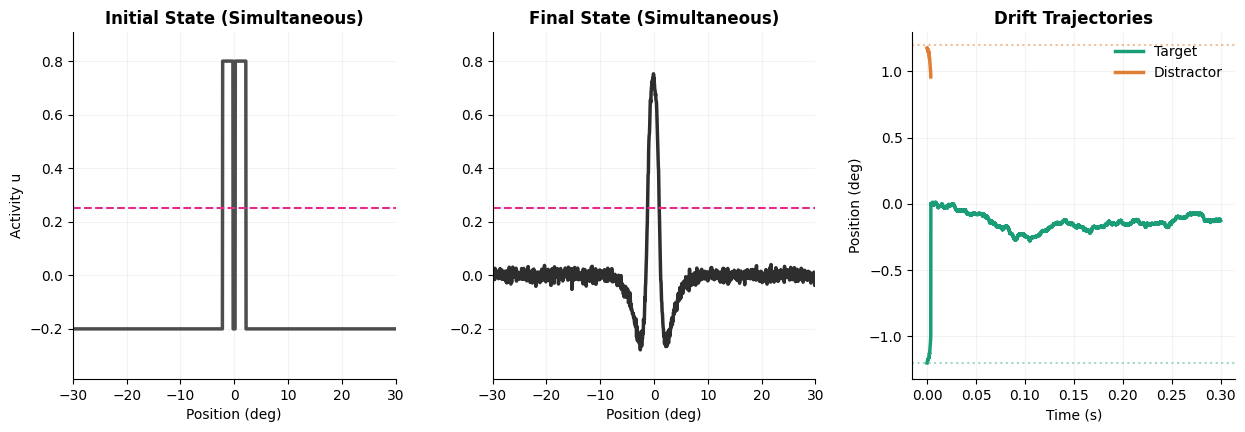

In [3]:
# Run with noise (using same config and simulator from above)
res1 = sim.run_trial(target_loc=target_repel, dist_loc=distractor_repel, 
                     with_noise=True, experiment_type="simultaneous")

res2 = sim.run_trial(target_loc=target_attract, dist_loc=distractor_attract, 
                     with_noise=True, experiment_type="simultaneous")

# Plot results
plot_results(sim.grid, res1, target_loc=target_repel, dist_loc=distractor_repel, 
             condition="Simultaneous", dt=config.dt, theta=config.theta)
plot_results(sim.grid, res2, target_loc=target_attract, dist_loc=distractor_attract, 
             condition="Simultaneous", dt=config.dt, theta=config.theta)

### 1.2 Reduced Model (no noise)

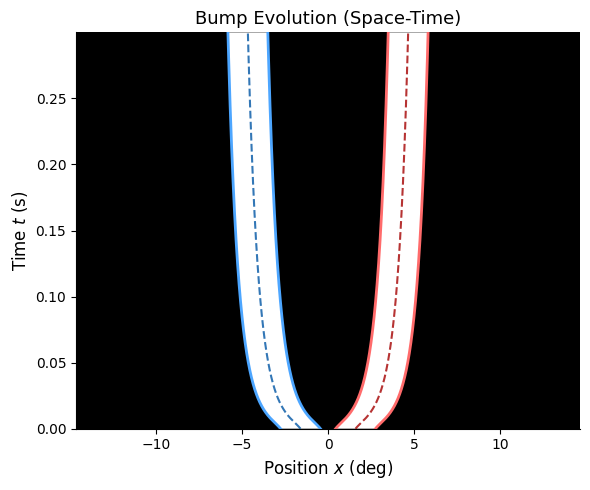

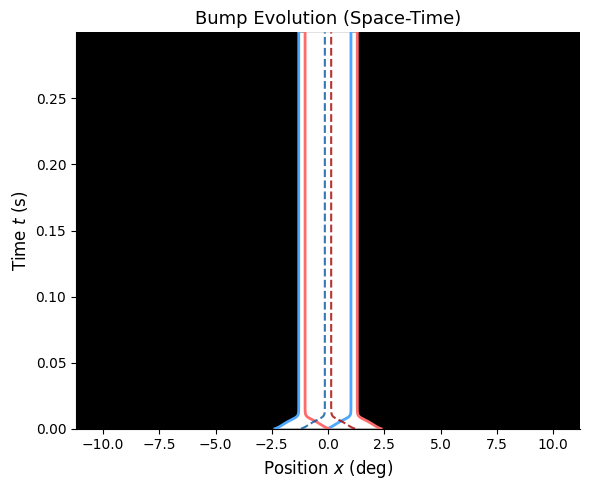

In [4]:
# Simplified model (no noise)
config_simplified = SimulationConfig(
    sim_mode=SimulationMode.SIMPLIFIED,
    ring_mode=RingMode.SINGLE,
    grid=GridParams(dx=0.05),
    time=TimeParams(eps=0.02, T_total=300),
    input=InputParams(width_input=2),
    lateral_kernel=LateralKernelParams(kernel_type=LateralKernelType.KILPATRICK),
)

sim_simplified = create_simulator(config_simplified)

target_repel = -1.6
distractor_repel = 1.6
res1 = sim_simplified.run_trial(target_loc=target_repel, dist_loc=distractor_repel, 
                                with_noise=False, experiment_type="simultaneous")

target_attract = -1.2
distractor_attract = 1.2
res2 = sim_simplified.run_trial(target_loc=target_attract, dist_loc=distractor_attract, 
                                with_noise=False, experiment_type="simultaneous")

# Plot space-time diagrams
plot_space_time(res1, config_simplified.dt)
plot_space_time(res2, config_simplified.dt)

### Reduced Model (with noise)

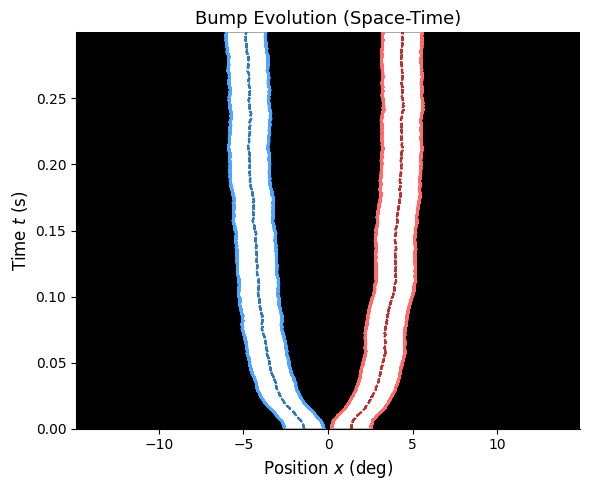

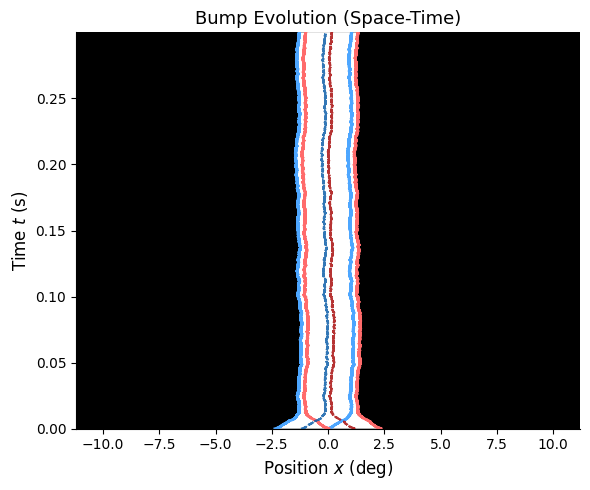

In [5]:
# Reduced model with noise
target_repel = -1.4
distractor_repel = 1.4
res1 = sim_simplified.run_trial(target_loc=target_repel, dist_loc=distractor_repel, 
                                with_noise=True, experiment_type="simultaneous")

target_attract = -1.2
distractor_attract = 1.2
res2 = sim_simplified.run_trial(target_loc=target_attract, dist_loc=distractor_attract, 
                                with_noise=True, experiment_type="simultaneous")

# Plot space-time diagrams
plot_space_time(res1, config_simplified.dt)
plot_space_time(res2, config_simplified.dt)

### Conclusion

The implementation seems to reproduce the desired behavior, validated by reproducing the figures found in the Kilpatrick paper. Full neural field model as well as SDE reductive model function as expected. We can start looking for a kernel that reproduces the desired behavior.

## Desired force function

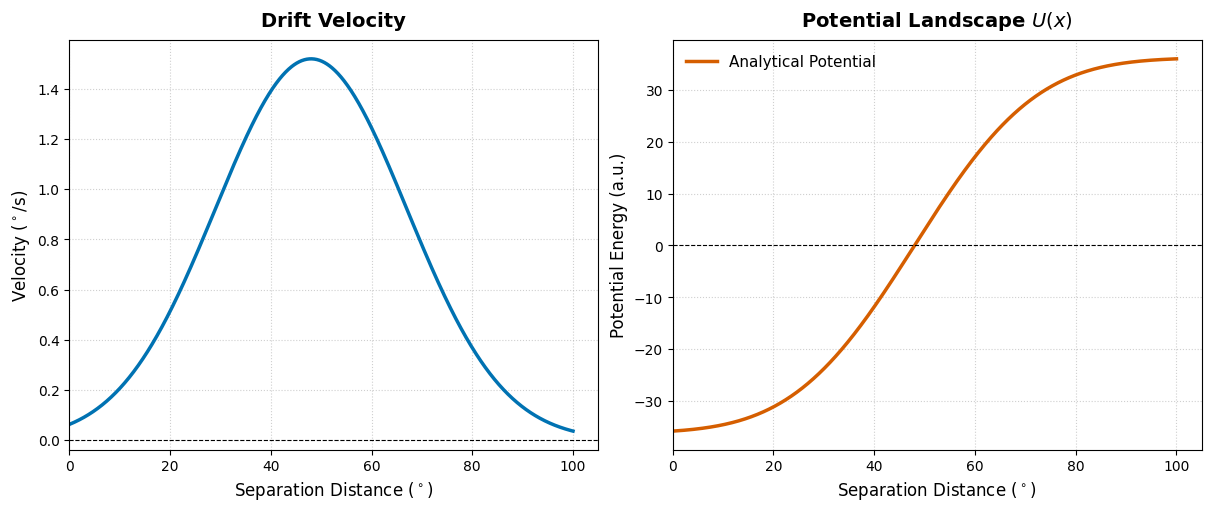

In [ ]:
# first we derive the force function by assuming velocity = force, bias = velocity * delay time -> velocity = bias / delay time
from scipy.special import erf
experiment_timescale = 2.5
x = np.linspace(0,100, 1000)
# target function
def g(x):
    return 3.8 * np.exp(-(x - 48)**2 / (2 * 19**2))

# now we get the integral of the function to get the potential landscape
def G(x):
    A = 3.8 / experiment_timescale
    mu = 48
    sigma = 19
    coeff = A * sigma * np.sqrt(np.pi / 2)
    return coeff * erf((x - mu) / (sigma * np.sqrt(2)))

force = g(x)
potential = G(x)

plot_potential_and_force(x, force, potential, experiment_timescale)


In [ ]:
# Test stability of default triple gaussian kernel
config_triple = SimulationConfig(
    lateral_kernel=LateralKernelParams(kernel_type=LateralKernelType.TRIPLE_GAUSSIAN),
)

# Create grid and kernel
grid = SpatialGrid.from_params(config_triple.grid)
lateral_kernel = create_lateral_kernel(config_triple.lateral_kernel)
w_lat = lateral_kernel.compute(grid.x)

# Check stability
check_stability(grid.x, grid.dx, w_lat, theta=config_triple.theta, verbose=True)

--- Kernel Stability ---
Found Stable Bump: Width = 7.78°


(True, 7.777888778826296)

## Search for a within-ring kernel 

Generating 50000 random parameter sets...
Screening kernels...
  Processed 0/50000...
  Processed 5000/50000...
  Processed 10000/50000...
  Processed 15000/50000...
  Processed 20000/50000...
  Processed 25000/50000...
  Processed 30000/50000...
  Processed 35000/50000...
  Processed 40000/50000...
  Processed 45000/50000...
  A_ex: 1.10 - 3.82
  s_ex: 1.27 - 7.35
  A_inh: 0.62 - 1.95
  s_inh: 12.26 - 29.44
  A_att: 0.02 - 0.69
  s_att: 31.64 - 94.32

Generating correlation plots...


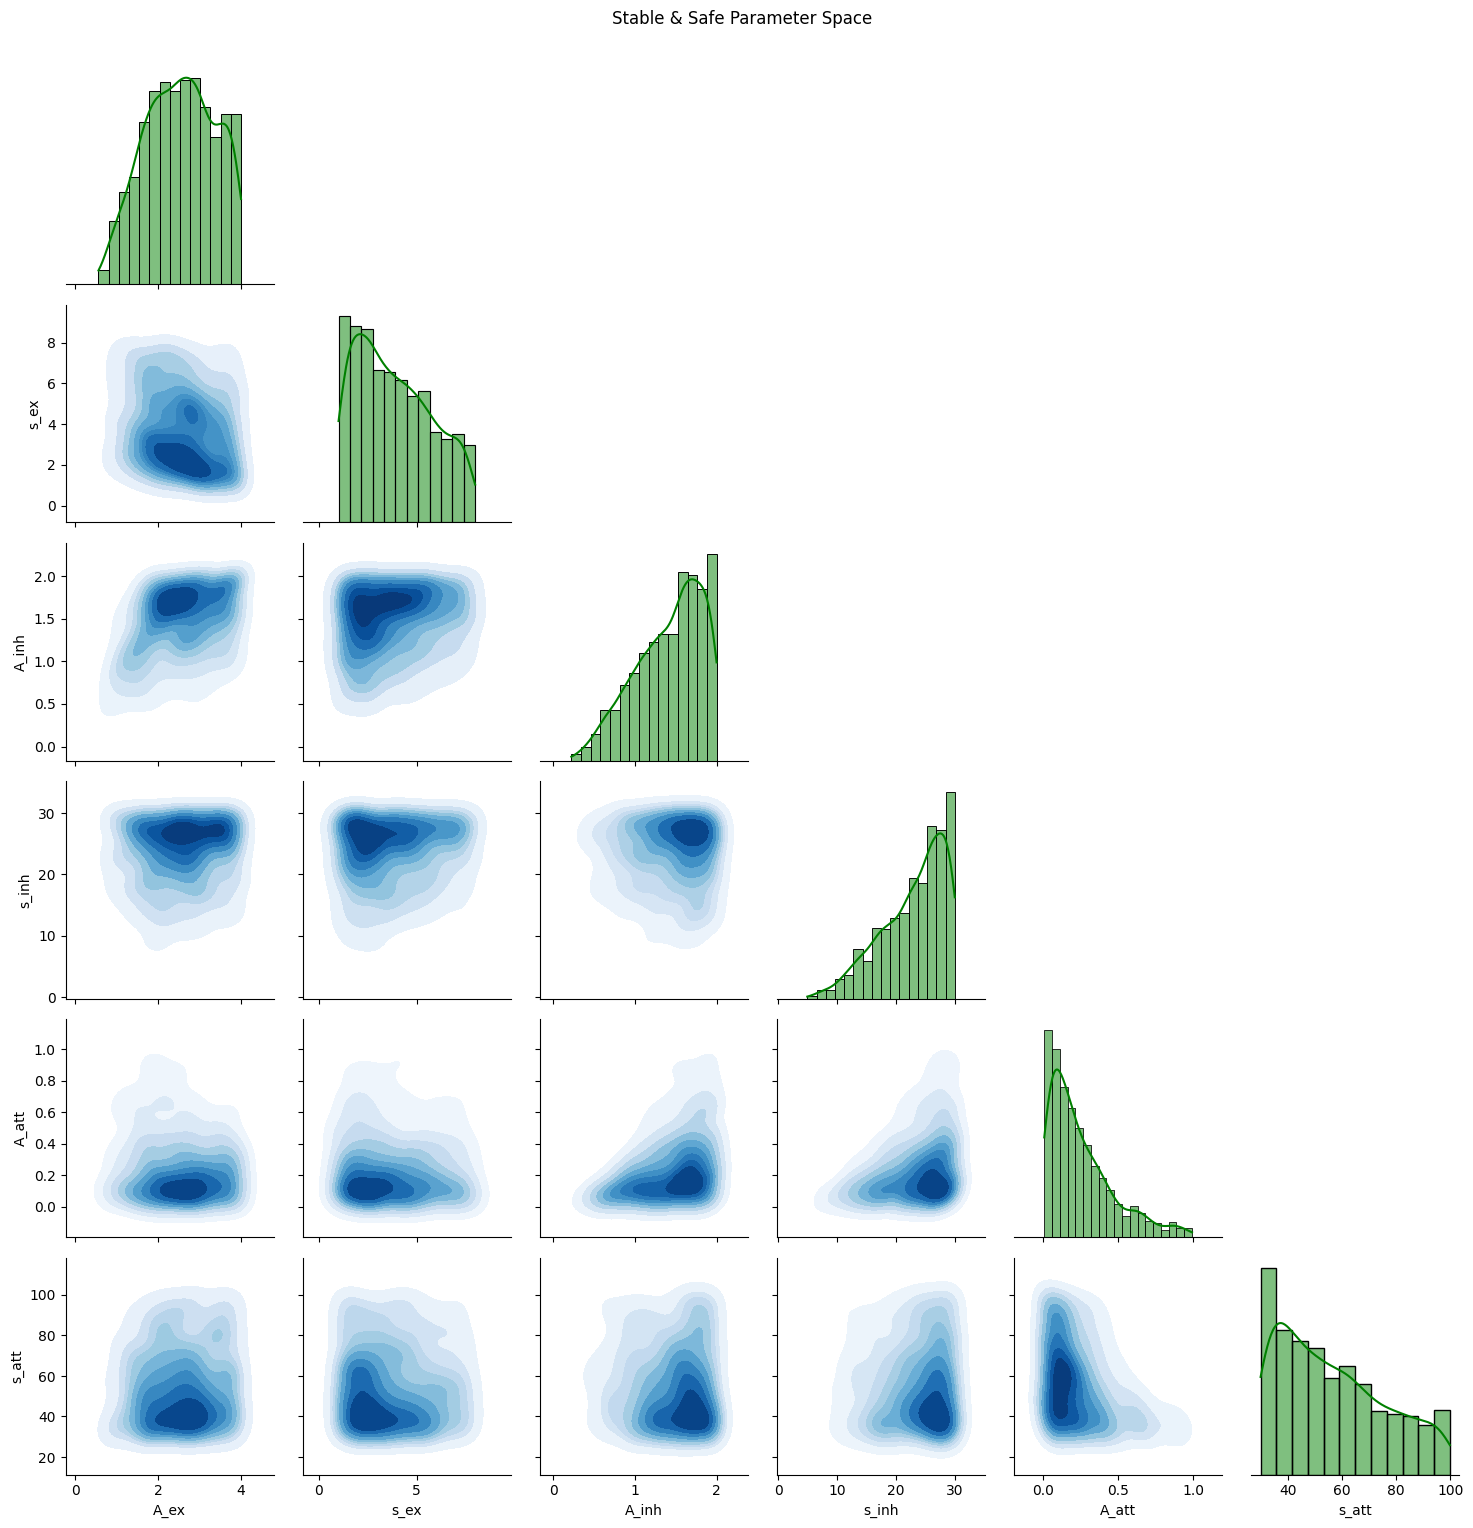


--- RESULTS ---
Found 5470 stable kernels.
Average Stable Width: 10.87°
Saved to ../data/stable_params.csv


,A_ex,s_ex,A_inh,s_inh,A_att,s_att,net_drive,stable_width
0,1.043528,5.339865,0.833554,24.172912,0.103255,90.255927,-5.257773,8.207012
1,3.362097,3.574674,1.677801,9.937862,0.095606,33.957107,-1.408852,11.692855
2,1.980601,4.447863,1.668412,25.364507,0.241750,92.488248,-11.149990,6.563830
3,1.874849,1.525524,1.129086,24.592532,0.157339,63.122312,-14.975379,3.337718
4,3.665697,6.527424,1.161966,24.579485,0.044303,75.835391,-1.273238,37.794785
...,...,...,...,...,...,...,...,...
5465,3.633865,2.723305,1.129460,28.843277,0.210698,62.213635,-9.572946,13.837335
5466,2.050672,6.183443,1.681641,28.101645,0.199383,94.562434,-15.722556,9.337811
5467,2.488929,2.197085,1.208953,28.368104,0.646086,31.135916,-8.710838,12.170953
5468,2.756725,3.817993,1.808815,23.992368,0.441068,34.839184,-17.506166,9.647607


In [ ]:
search_stable_kernels(n_samples=50_000)

(5470, 8)
(4093, 8)
Remaining Kernels: 21


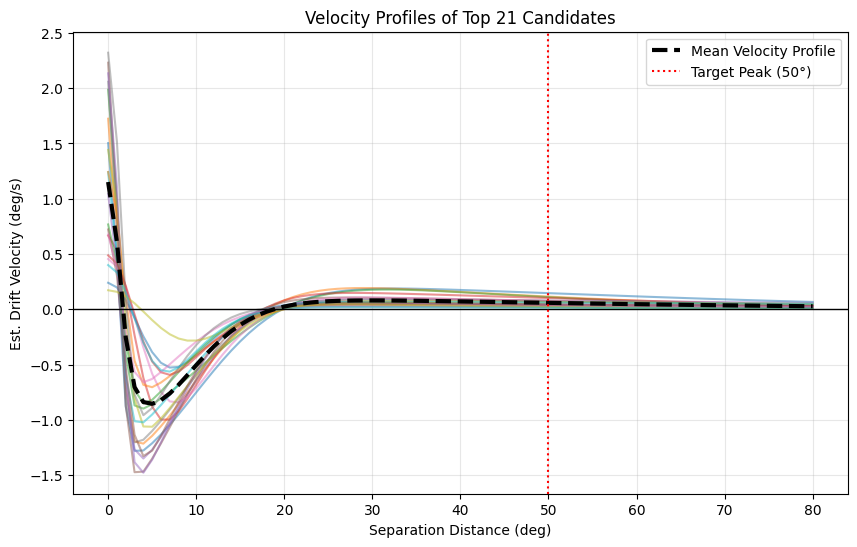

Saved filtered candidates to '../data/candidates.csv'


In [ ]:
# filter for our requirements, long range interaction
import pandas as pd

df = pd.read_csv("../data/stable_params.csv")
print(df.shape)
candidates = df.query("s_att > 40")
print(candidates.shape)

distances = range(0, 81)

for d in distances:
    df[f'v_{d}'] = calculate_force_at_dist(df, float(d))

# 4. Filter
#Peaking around 50 (v50 > v20 AND v50 > v80) and purely attractive (v20 > 0)
candidates = df.query("v_50 > v_80 and v_50 > v_20 and v_20 >0")

print(f"Remaining Kernels: {len(candidates)}")

plot_candidates(candidates, distances)

In [ ]:
df_subset = candidates.sample(n=10, random_state=42)

# Define function to create config from a DataFrame row
def make_config(row):
    """Create SimulationConfig from a row of kernel parameters."""
    return SimulationConfig(
        sim_mode=SimulationMode.FULL,
        ring_mode=RingMode.SINGLE,
        time=TimeParams(T_total=2000, dt=0.1),
        input=InputParams(theta=0.25),
        lateral_kernel=LateralKernelParams(
            kernel_type=LateralKernelType.TRIPLE_GAUSSIAN,
            A_ex=row['A_ex'],
            sig_ex=row['s_ex'],
            A_inh=row['A_inh'],
            sig_inh=row['s_inh'],
            A_attr=row['A_att'],
            sig_attr=row['s_att'],
        ),
        physics=PhysicsParams(stable_width=row.get('stable_width')),
    )

# Run empirical validation
df_verified = run_empirical_validation(
    df_subset, 
    create_config_fn=make_config,
    create_simulator_fn=create_simulator,
)

In [ ]:
## visualize a single run
random_row = candidates.sample(1).iloc[0]

print(f"--- Visualizing Kernel ID: {random_row.name} ---")

# Create configuration from the candidate parameters
stable_width = random_row["stable_width"]
config_viz = SimulationConfig(
    sim_mode=SimulationMode.FULL,
    ring_mode=RingMode.SINGLE,
    grid=GridParams(dx=0.005),
    time=TimeParams(T_total=700, dt=0.01),
    input=InputParams(
        theta=0.25,
        amp_dist=5,
        amp_target=5,
        width_input=stable_width * 1.6,
    ),
    lateral_kernel=LateralKernelParams(
        kernel_type=LateralKernelType.TRIPLE_GAUSSIAN,
        A_ex=random_row['A_ex'],
        sig_ex=random_row['s_ex'],
        A_inh=random_row['A_inh'],
        sig_inh=random_row['s_inh'],
        A_attr=random_row['A_att'],
        sig_attr=random_row['s_att'],
    ),
    physics=PhysicsParams(stable_width=stable_width),
)

# Create and visualize the kernel
grid_viz = SpatialGrid.from_params(config_viz.grid)
lateral_kernel_viz = create_lateral_kernel(config_viz.lateral_kernel)
physics_viz = compute_bump_physics(
    grid=grid_viz,
    lateral_kernel=lateral_kernel_viz,
    cross_kernel=None,
    theta=config_viz.theta,
    ring_mode=config_viz.ring_mode,
    stable_width=stable_width,
)

plot_kernel(grid_viz, lateral_kernel_viz, physics=physics_viz, theta=config_viz.theta)

# Create simulator and run
sim_viz = create_simulator(config_viz)

target_loc = 0.0
dist_loc = 50.0  

print(f"Running simulation with target at {target_loc}° and distractor at {dist_loc}°...")

res = sim_viz.run_trial(
    target_loc=target_loc, 
    dist_loc=dist_loc, 
    experiment_type="simultaneous", 
    with_noise=False
)

plot_results(sim_viz.grid, res, target_loc=target_loc, dist_loc=dist_loc, 
             condition="simultaneous", dt=config_viz.dt, theta=config_viz.theta)

### Conclusion

Based on what was shown, it seems implausible that a stable within-ring kernel reproducing the desired behavior (only attraction, Gaussian-like) exists. 

To decouple stability from behavior, we move to modelling not two bumps on the same ring, but two bumps on separate rings, interacting via a between-ring kernel. This allows us to define a purely attractive force without the stability constraints.

## Search for between-ring kernel

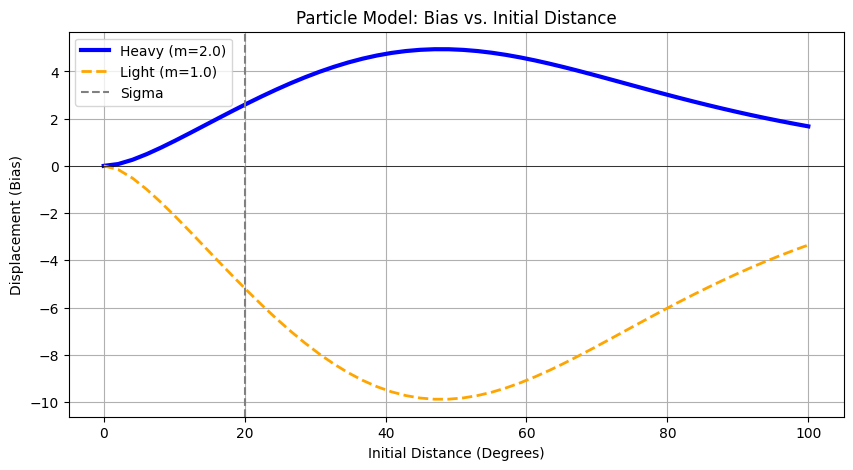

(array([  0.        ,   2.04081633,   4.08163265,   6.12244898,
          8.16326531,  10.20408163,  12.24489796,  14.28571429,
         16.32653061,  18.36734694,  20.40816327,  22.44897959,
         24.48979592,  26.53061224,  28.57142857,  30.6122449 ,
         32.65306122,  34.69387755,  36.73469388,  38.7755102 ,
         40.81632653,  42.85714286,  44.89795918,  46.93877551,
         48.97959184,  51.02040816,  53.06122449,  55.10204082,
         57.14285714,  59.18367347,  61.2244898 ,  63.26530612,
         65.30612245,  67.34693878,  69.3877551 ,  71.42857143,
         73.46938776,  75.51020408,  77.55102041,  79.59183673,
         81.63265306,  83.67346939,  85.71428571,  87.75510204,
         89.79591837,  91.83673469,  93.87755102,  95.91836735,
         97.95918367, 100.        ]),
 [0.0,
  0.07743219787394238,
  0.2592705902522098,
  0.5010188260015525,
  0.7789800615155693,
  1.078856829254505,
  1.391173466711964,
  1.7091539256331825,
  2.0276321976339435,
  2.34244949

In [12]:
# if we go back to the simplest model, we can look at the interaction of two interia-less particles with different mass
particle_model()


The interaction force found in the (even further) reduced particle simulation reproduces the empirical data perfectly and is tunable to match the exact curves needed. In the next steps we will try to determine if the same interaction kernel also works for the SDE and full simulation.

Note that the function used here is much too complicated, a simple Gaussian force will produce the same results.

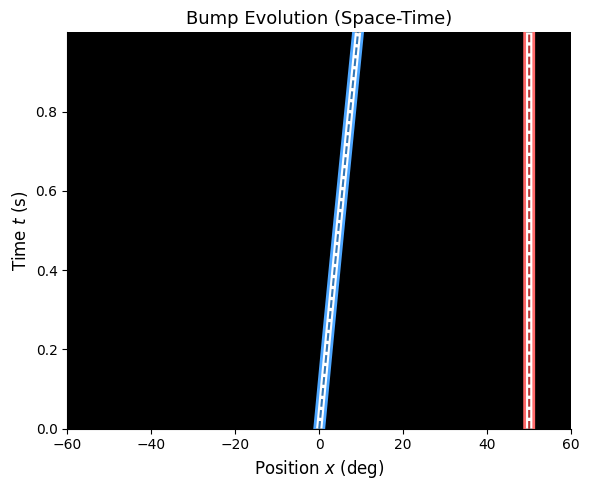

Bias: 9.2394°


In [26]:
# Dual-ring simplified model
config_dual = SimulationConfig(
    sim_mode=SimulationMode.SIMPLIFIED,
    ring_mode=RingMode.DUAL,
    grid=GridParams(dx=0.005),
    time=TimeParams(T_total=1000),
    lateral_kernel=LateralKernelParams(kernel_type=LateralKernelType.KILPATRICK),
    cross_kernel=CrossKernelParams(
        kernel_type=CrossKernelType.GAUSSIAN,
        J_cross=0.3,
    ),
)

sim_dual = create_simulator(config_dual)
dual_res = sim_dual.run_trial(with_noise=False, dist_loc=50, interaction="nonsymmetric")

plot_space_time(dual_res, config_dual.dt)
print(f"Bias: {dual_res.bias:.4f}°")

We get a linear drift, with a velocity that depends on the coupling strength $J_{cross}$.

In [24]:
#### --- TESTING ONLY --- ####

# import numpy as np
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from IPython.display import display

# def f(x, A_ex1=0.1, A_ex2=0.1, c1=20, c2=-40,sig_ex1=8, sig_ex2=8, center=0):
#     g1 = A_ex1 * np.exp(-((x-c1-center)**2) / (2 * sig_ex1**2))
#     g2 = A_ex2 * np.exp(-((x-c2-center)**2) / (2 * sig_ex2**2))
#     return g1 + g2

# x = np.linspace(-180, 180, 1000)

# center_slider = widgets.FloatSlider(
#     value=50, min=-180, max=180, step=0.5,
#     description="center", continuous_update=True,layout=widgets.Layout(width="800px", height="40px"),
#     style={"description_width": "80px"}
# )

# def plot(center):
#     y0 = f(x)
#     y1 = f(x, center=center)
#     u  = y0 + y1

#     plt.figure(figsize=(7, 4))
#     plt.plot(x, y0, label="f(x)")
#     plt.plot(x, y1, label=f"f(x, center={center:.0f})")
#     plt.plot(x, u,  label="u = sum")
#     plt.ylim(0, 3)
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.show()

# out = widgets.interactive_output(plot, {"center": center_slider})
# display(center_slider, out)

In [ ]:
### you can just run this instead of the imports at the top ###

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

# Re-import if needed (uses same imports as the first cell)
from neural_field import SimulationConfig, create_simulator
from neural_field.config import SimulationMode, RingMode, LateralKernelType, CrossKernelType
from neural_field.config import GridParams, TimeParams, LateralKernelParams, CrossKernelParams, InputParams
from neural_field.core import SpatialGrid
from neural_field.visualization import plot_space_time, plot_results, plot_candidates, plot_potential_and_force
from neural_field.analysis import check_stability, search_stable_kernels
from neural_field.analysis.validation import calculate_force_at_dist, run_empirical_validation, particle_model
from neural_field.kernels import create_lateral_kernel, create_cross_kernel
import matplotlib.pyplot as plt
import numpy as np

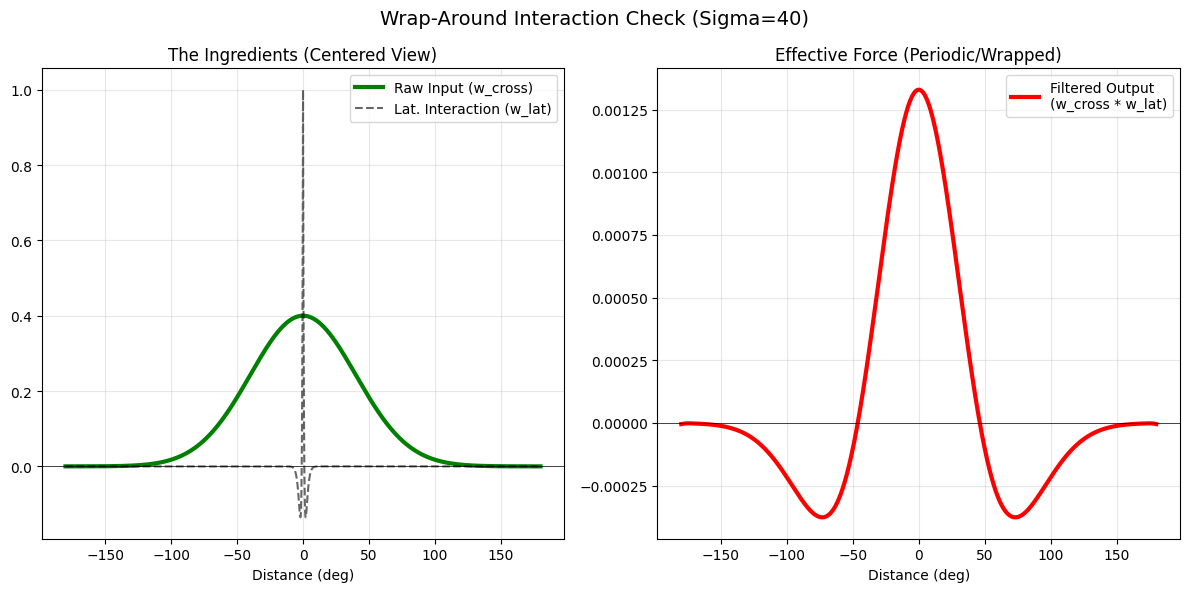

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.fft import fft, ifft, fftshift, ifftshift

# Create configuration for analysis
config_analysis = SimulationConfig(
    sim_mode=SimulationMode.SIMPLIFIED,
    ring_mode=RingMode.DUAL,
    grid=GridParams(dx=0.05),
    time=TimeParams(T_total=500, eps=0.03),
    lateral_kernel=LateralKernelParams(kernel_type=LateralKernelType.KILPATRICK),
    cross_kernel=CrossKernelParams(
        kernel_type=CrossKernelType.GAUSSIAN,
        J_cross=0.4,
        sig_cross=40,
    ),
    input=InputParams(amp_dist=1),
)

# Create grid and kernels
grid_analysis = SpatialGrid.from_params(config_analysis.grid)
lateral_kernel_analysis = create_lateral_kernel(config_analysis.lateral_kernel)
cross_kernel_analysis = create_cross_kernel(config_analysis.cross_kernel)

# Get kernel values
dx = grid_analysis.dx
x_grid = grid_analysis.x
w_cross = cross_kernel_analysis.compute(x_grid)
w_lat = lateral_kernel_analysis.compute(x_grid)

# Standardize: Ensure we start with "Visually Centered" arrays (Peak in Middle)
if np.argmax(w_cross) == 0: 
    w_cross = fftshift(w_cross)
if np.argmax(w_lat) == 0:
    w_lat = fftshift(w_lat)

# --- CALCULATE CONVOLUTION WITH WRAP-AROUND (FFT METHOD) ---
# A. Move to "Physics Coordinates" (Peak at Index 0)
input_fft_ready = ifftshift(w_cross)
kernel_fft_ready = ifftshift(w_lat)

# B. Perform Convolution in Frequency Domain
conv_res = ifft(fft(input_fft_ready) * fft(kernel_fft_ready)) * dx

# C. Move back to "Visual Coordinates" (Peak in Center)
effective_potential = fftshift(conv_res.real)

# --- PLOTTING ---
plt.figure(figsize=(12, 6))

# Plot A: The Ingredients
plt.subplot(1, 2, 1)
plt.plot(x_grid, w_cross, 'g-', linewidth=3, label='Raw Input (w_cross)')
plt.plot(x_grid, w_lat, 'k--', alpha=0.6, label='Lat. Interaction (w_lat)')
plt.title("The Ingredients (Centered View)")
plt.xlabel("Distance (deg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='k', linewidth=0.5)

# Plot B: The Result (The "Effective" Landscape)
plt.subplot(1, 2, 2)
plt.plot(x_grid, effective_potential, 'r-', linewidth=3, label='Filtered Output\n(w_cross * w_lat)')

plt.title("Effective Force (Periodic/Wrapped)")
plt.xlabel("Distance (deg)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='k', linewidth=0.5)

plt.suptitle(f"Wrap-Around Interaction Check (Sigma={config_analysis.cross_kernel.sig_cross})", fontsize=14)
plt.tight_layout()
plt.show()

Since we convolve a mexican hat with a gaussian, the result is another mexican hat. This means we need to find an effective kernel = (interaction kernel * within-ring kernel) that is close to gaussian.

Running simulation for 22 distances...
Running Experiment in mode: simultaneous
Dist: -100.0 deg | Bias: -1.4072
Running Experiment in mode: simultaneous
Dist: -90.5 deg | Bias: -2.3092
Running Experiment in mode: simultaneous
Dist: -81.0 deg | Bias: -3.5286
Running Experiment in mode: simultaneous
Dist: -71.4 deg | Bias: -4.9452
Running Experiment in mode: simultaneous
Dist: -61.9 deg | Bias: -6.2478
Running Experiment in mode: simultaneous
Dist: -52.4 deg | Bias: -7.0383
Running Experiment in mode: simultaneous
Dist: -42.9 deg | Bias: -7.0615
Running Experiment in mode: simultaneous
Dist: -33.3 deg | Bias: -6.3084
Running Experiment in mode: simultaneous
Dist: -23.8 deg | Bias: -4.9302
Running Experiment in mode: simultaneous
Dist: -14.3 deg | Bias: -3.1229
Running Experiment in mode: simultaneous
Dist: -4.8 deg | Bias: -1.0710
Running Experiment in mode: simultaneous
Dist: 4.8 deg | Bias: 1.0710
Running Experiment in mode: simultaneous
Dist: 14.3 deg | Bias: 3.1229
Running Experimen

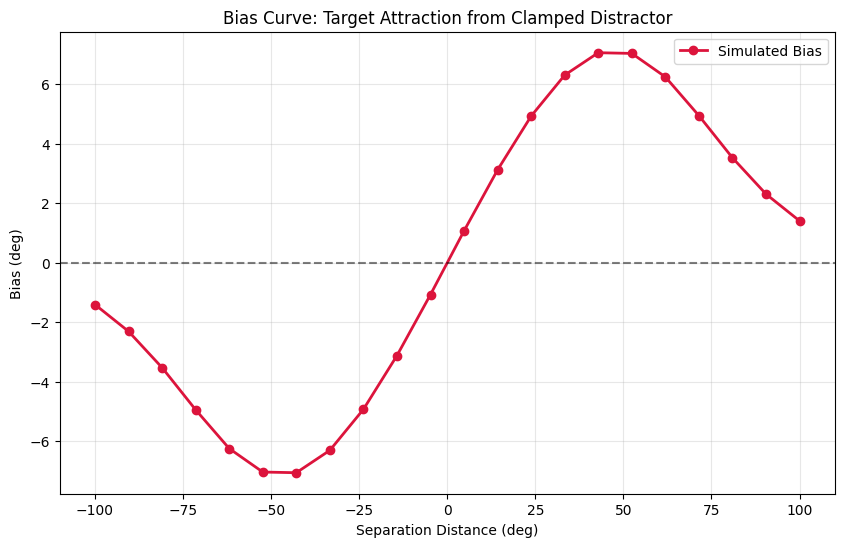

In [3]:
### Reproduction of the bias curve for the simplified model - without symmetric interaction ###

# Create simulator for bias sweep
sim_sweep = create_simulator(config_analysis)

separation_distances = np.linspace(-100, 100, 22)

def run_and_plot(sim, distances, **kwargs):
    print(f"Running simulation for {len(distances)} distances...")
    start_time = time.time()
    biases = []
    final_values = []


    for dist in distances:
        res = sim.run_trial(with_noise=False, dist_loc=dist, **kwargs)
        
        biases.append(res.bias)
        final_values.append(res.final_u)
        print(f"Dist: {dist:.1f} deg | Bias: {res.bias:.4f}")

    print(f"Completed in {time.time() - start_time:.2f} seconds.")

    # Plot bias curve
    plt.figure(figsize=(10, 6))
    plt.plot(separation_distances, biases, 'o-', color='crimson', linewidth=2, label="Simulated Bias")

    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel("Separation Distance (deg)")
    plt.ylabel("Bias (deg)")
    plt.title("Bias Curve: Target Attraction from Clamped Distractor")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


run_and_plot(sim_sweep, separation_distances)

Running simulation for 22 distances...
Running Experiment in mode: empirical
Dist: -100.0 deg | Bias: -0.7511
Running Experiment in mode: empirical
Dist: -90.5 deg | Bias: -1.2068
Running Experiment in mode: empirical
Dist: -81.0 deg | Bias: -1.8108
Running Experiment in mode: empirical
Dist: -71.4 deg | Bias: -2.5233
Running Experiment in mode: empirical
Dist: -61.9 deg | Bias: -3.2431
Running Experiment in mode: empirical
Dist: -52.4 deg | Bias: -3.8128
Running Experiment in mode: empirical
Dist: -42.9 deg | Bias: -4.0612
Running Experiment in mode: empirical
Dist: -33.3 deg | Bias: -3.8639
Running Experiment in mode: empirical
Dist: -23.8 deg | Bias: -3.1883
Running Experiment in mode: empirical
Dist: -14.3 deg | Bias: -2.0991
Running Experiment in mode: empirical
Dist: -4.8 deg | Bias: -0.7344
Running Experiment in mode: empirical
Dist: 4.8 deg | Bias: 0.7344
Running Experiment in mode: empirical
Dist: 14.3 deg | Bias: 2.0991
Running Experiment in mode: empirical
Dist: 23.8 deg | B

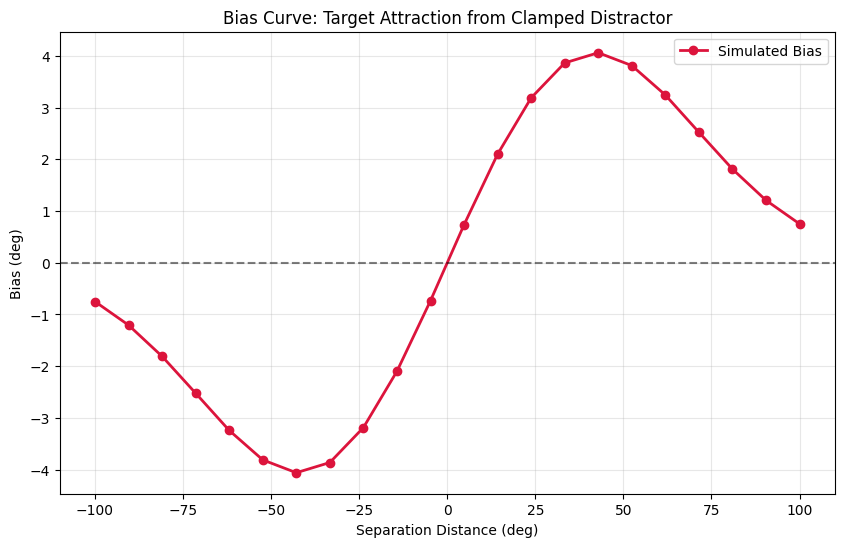

In [4]:
### Using the exact experimental paradigm ###

config_experiment = SimulationConfig(
    sim_mode=SimulationMode.SIMPLIFIED,
    ring_mode=RingMode.DUAL,
    grid=GridParams(dx=0.05),
    time=TimeParams(T_total=3250, eps=0.03),
    lateral_kernel=LateralKernelParams(kernel_type=LateralKernelType.KILPATRICK),
    cross_kernel=CrossKernelParams(
        kernel_type=CrossKernelType.GAUSSIAN,
        J_cross=0.15,
        sig_cross=40,
    ),
    input=InputParams(amp_dist=1),
)

experiment = create_simulator(config_experiment)

run_and_plot(experiment, separation_distances, dist_onset=1250, dist_dur=750, experiment_type="empirical")